# 1. Setting up

In [40]:
import torch
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [41]:
!nvidia-smi

Mon Mar  3 16:01:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   41C    P8              2W /   55W |    2342MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 2. Data preparation

## a) Checking images

In [42]:
import os

data_path = "data"
test_path = data_path + "/test/20-29"
train_path = data_path + "/train/20-29"

In [43]:
def walk_through_dir(dir):
    for dirpaths, dirnames, filenames in os.walk(dir):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpaths}")
walk_through_dir(data_path)

There are 2 directories and 0 images in data
There are 9 directories and 0 images in data/train
There are 7 directories and 0 images in data/train/30-39
There are 0 directories and 1093 images in data/train/30-39/Southeast Asian
There are 0 directories and 1782 images in data/train/30-39/Middle Eastern
There are 0 directories and 1607 images in data/train/30-39/Indian
There are 0 directories and 1267 images in data/train/30-39/East Asian
There are 0 directories and 2228 images in data/train/30-39/White
There are 0 directories and 1296 images in data/train/30-39/Black
There are 0 directories and 1557 images in data/train/30-39/Latino_Hispanic
There are 7 directories and 0 images in data/train/10-19
There are 0 directories and 670 images in data/train/10-19/Southeast Asian
There are 0 directories and 392 images in data/train/10-19/Middle Eastern
There are 0 directories and 639 images in data/train/10-19/Indian
There are 0 directories and 544 images in data/train/10-19/East Asian
There ar

### Check the sizes of the images

In [44]:
from PIL import Image
import os
from collections import Counter

In [45]:
size_counts = Counter()
for subfolder in os.listdir(train_path):
    subfolder_path = train_path + "/" + subfolder
    for filename in os.listdir(subfolder_path):
            file_path = subfolder_path + "/" + filename
            with Image.open(file_path) as img:
                size = img.size  # (width, height)
                size_counts[size] += 1

for size, count in size_counts.items():
    print(f'Size {size}: {count} images')

Size (224, 224): 11335 images


## b) Creating datasets

In [46]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_path)
test_data = datasets.ImageFolder(root=test_path)
class_names = train_data.classes

## c) Data preprocessing

### i) Datasets before

In [47]:
def imgs_per_class(dataset):
    result = {}
    labels = [label for _, label in dataset.samples]
    class_counts = Counter(labels) 
    for class_ind, num in class_counts.items():
        result[class_names[class_ind]] = num
    return result
imgs_per_class(train_data), imgs_per_class(test_data)

({'Black': 1402,
  'East Asian': 1863,
  'Indian': 1373,
  'Latino_Hispanic': 1527,
  'Middle Eastern': 1282,
  'Southeast Asian': 1639,
  'White': 2249},
 {'Black': 185,
  'East Asian': 265,
  'Indian': 164,
  'Latino_Hispanic': 181,
  'Middle Eastern': 172,
  'Southeast Asian': 220,
  'White': 281})

### ii) Downsample the datasets

In [48]:
def downsample_dataset(dataset):
    # Get indices of each class
    class_indices = {cls: [] for cls in range(len(dataset.classes))}
    for idx, (_, label) in enumerate(dataset.samples):
        class_indices[label].append(idx)
    
    # Find the minimum class count
    min_count = min(len(indices) for indices in class_indices.values())
    
    # Downsample each class to the minimum count
    selected_indices = []
    for indices in class_indices.values():
        selected_indices.extend(np.random.choice(indices, min_count, replace=False))
    
    # Modify dataset in place
    dataset.samples = [dataset.samples[i] for i in selected_indices]
    dataset.targets = [dataset.targets[i] for i in selected_indices]
    
    return dataset

# Example usage
train_data = downsample_dataset(train_data)
test_data = downsample_dataset(test_data)

### iii) Datasets after

In [49]:
imgs_per_class(train_data), imgs_per_class(test_data)

({'Black': 1282,
  'East Asian': 1282,
  'Indian': 1282,
  'Latino_Hispanic': 1282,
  'Middle Eastern': 1282,
  'Southeast Asian': 1282,
  'White': 1282},
 {'Black': 164,
  'East Asian': 164,
  'Indian': 164,
  'Latino_Hispanic': 164,
  'Middle Eastern': 164,
  'Southeast Asian': 164,
  'White': 164})

### iv) Calculating class weights

In [50]:
class_train_imgs = imgs_per_class(train_data)
total_train_imgs = sum(class_train_imgs.values())
class_weights = [total_train_imgs / img_per_class for img_per_class in class_train_imgs.values()]
class_weights = torch.tensor(class_weights)
class_weights

tensor([7., 7., 7., 7., 7., 7., 7.])

## d) Creating transforms and apply data augmentation

In [51]:
from torchvision import transforms

img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(10), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05), 
    transforms.ToTensor()
])
simple_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()  
])
train_data.transform = img_transform
test_data.transform = simple_transform

## e) Turn datasets into dataloaders

In [52]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
num_workers = 4

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, 
                              num_workers=num_workers, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, 
                             num_workers=num_workers, shuffle=False)

## f) Visualize the images after changes

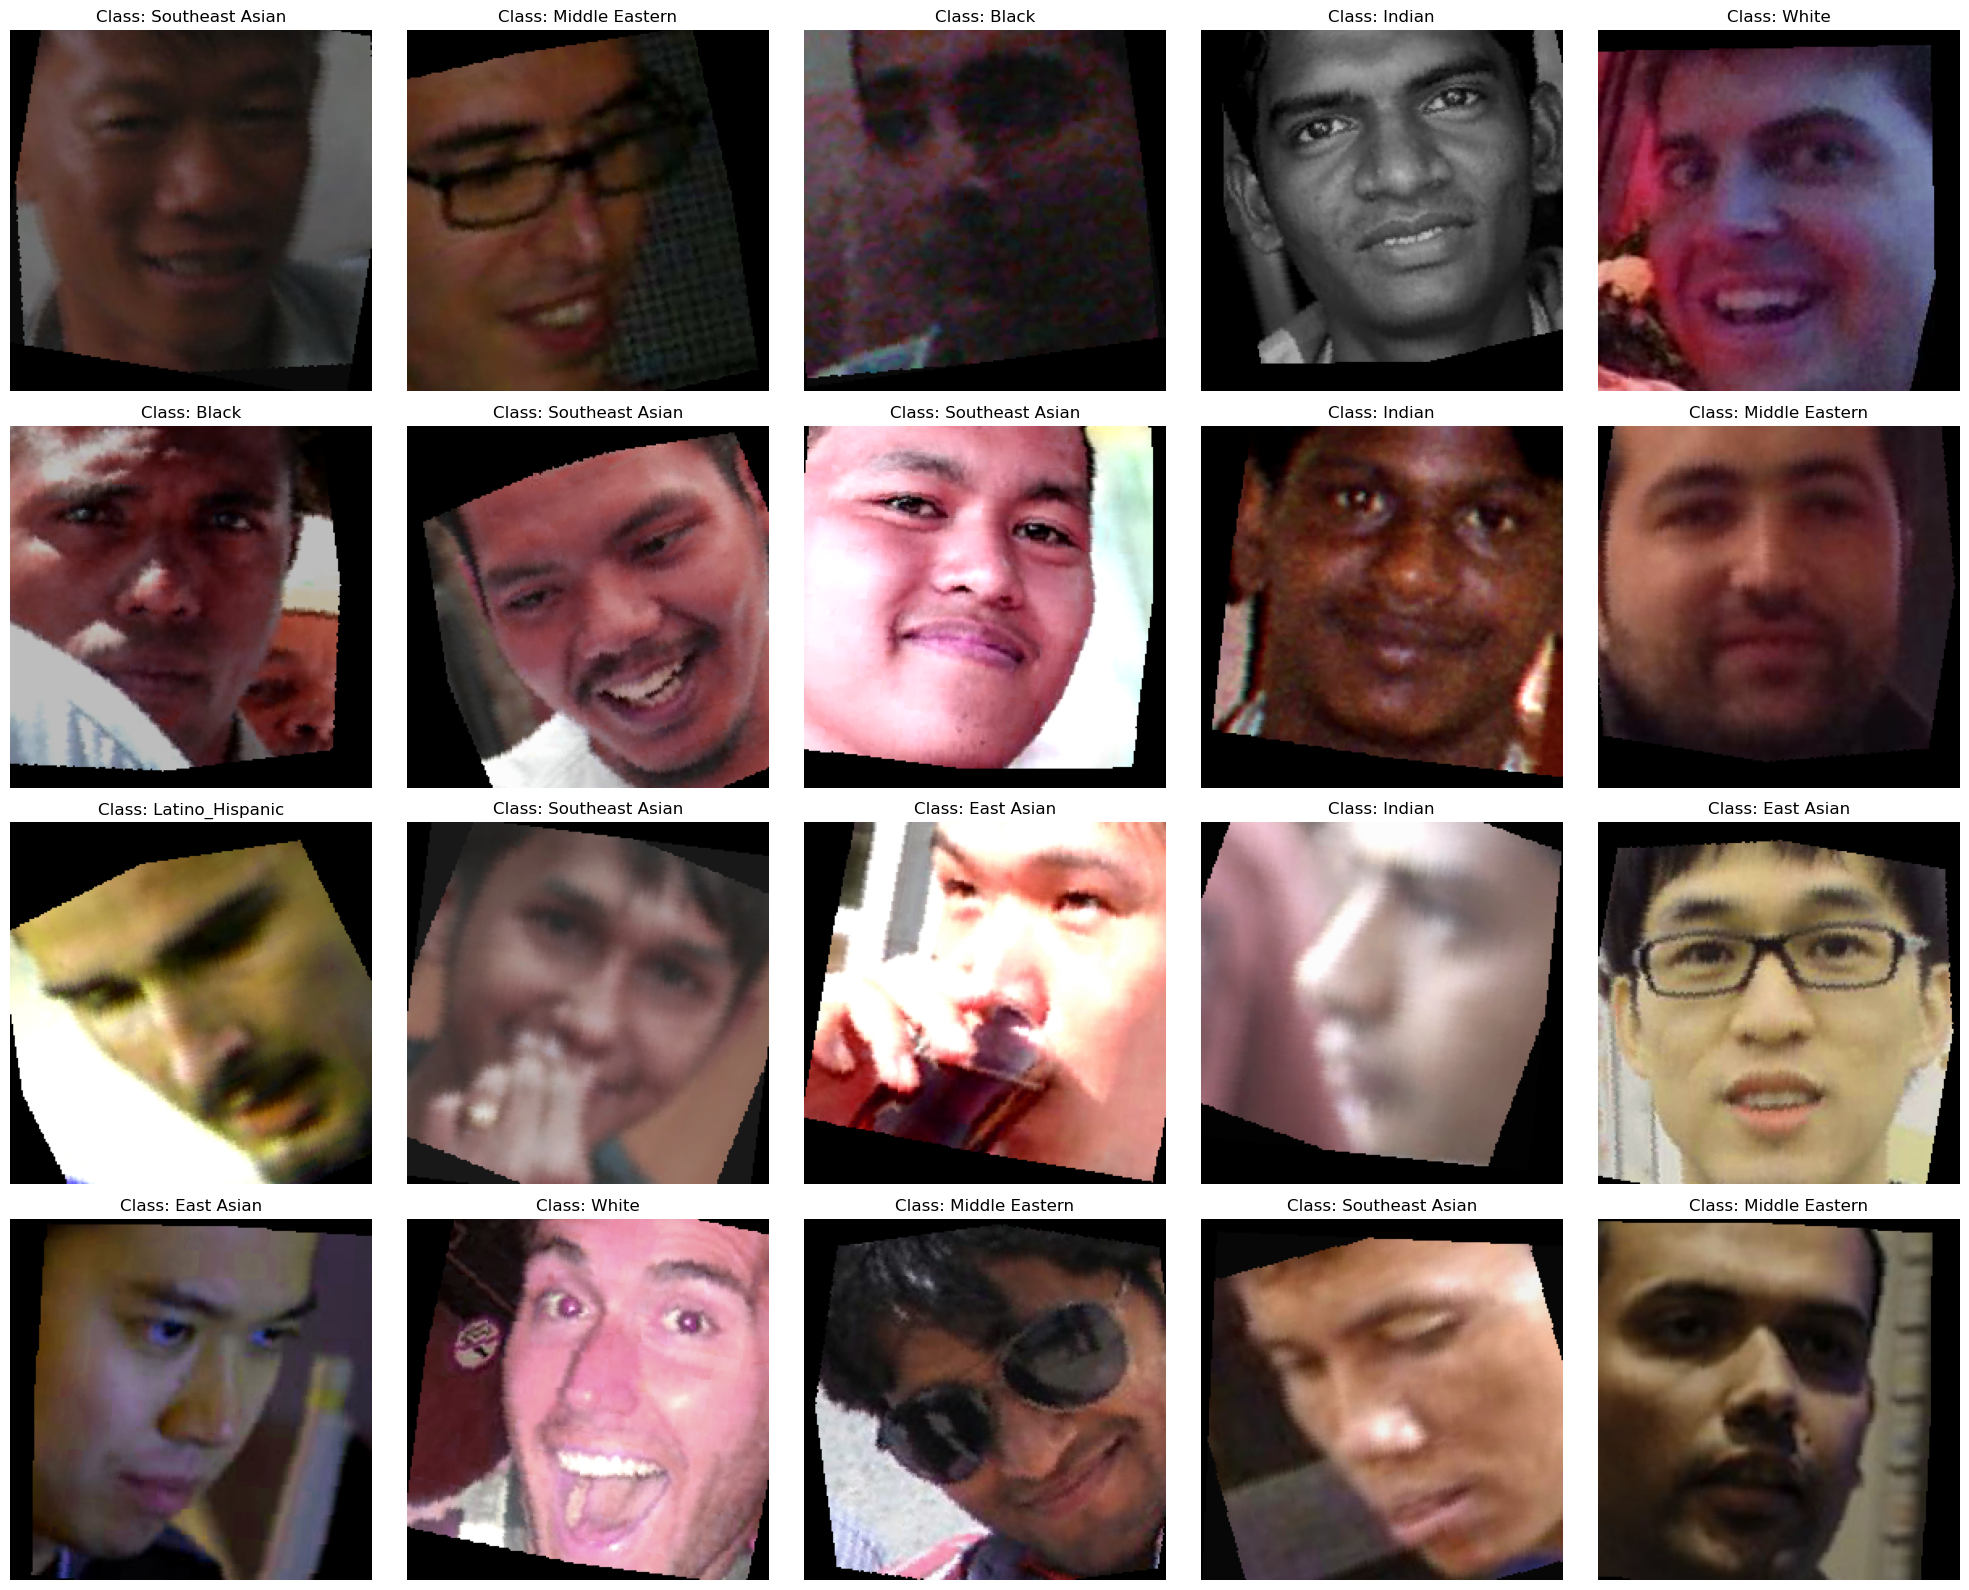

In [53]:
import matplotlib.pyplot as plt
import numpy as np


# Get one batch of images and labels
images, labels = next(iter(train_dataloader))

# Randomly select 20 indices
random_indices = np.random.choice(images.size(0), 20, replace=False)

# Convert from Tensor (C, H, W) to NumPy (H, W, C) for display
images = images.permute(0, 2, 3, 1).numpy()

plt.figure(figsize=(20, 16))
for i, idx in enumerate(random_indices):
    plt.subplot(4, 5, i+1)
    plt.imshow(images[idx])
    plt.title(f"Class: {class_names[labels[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [54]:
images, labels = next(iter(train_dataloader))
images = images.permute(0, 2, 3, 1).numpy()
images[0].shape

(224, 224, 3)

# 3. Create the model based on the Resnet architecture

In [55]:
from torch import nn
import torch.nn.functional as F
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)

        # Skip connections (Identity mapping)
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(num_features=out_channels)
            )
    def forward(self, x):
        identity = self.skip(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += identity
        return F.relu(x)

In [63]:
class CustomResnet(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.layer1 = ResidualBlock(32, 64, stride=2)
        self.layer2 = ResidualBlock(64, 128, stride=2)
        self.layer3 = ResidualBlock(128, 256, stride=2)

        self.pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)

In [69]:
model_0 = CustomResnet(num_classes=len(class_names))
model_0 = torch.compile(model_0)
torch.set_float32_matmul_precision('high')
model_0

OptimizedModule(
  (_orig_mod): CustomResnet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): ResidualBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (layer2): ResidualBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

# 4. Training and testing

## a) Train step and test step function

In [58]:
import torch.utils.data.dataloader


def train_step(model: nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, 
          optimizer: torch.optim.Optimizer, scheduler: torch.optim.lr_scheduler = None):
    model.train()
    train_loss, train_acc= 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = loss_fn(logits, y)
        train_loss += loss.cpu().detach().numpy() # for plotting loss in matplotlib later(requires numpy arr)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        labels = torch.argmax(torch.softmax(logits, dim=1), dim=1)
        train_acc += (labels == y).sum().item()/len(y)

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    if scheduler:
        scheduler.step(train_loss)
    return train_loss, train_acc

In [59]:
def test_step(model: nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module):
    model.eval()
    test_loss, test_acc = 0, 0 
    loss_for_scheduler = 0.0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = loss_fn(logits, y)
            test_loss += loss.cpu().detach().numpy() # for plotting loss in matplotlib later(requires numpy arr)

            labels = torch.argmax(torch.softmax(logits, dim=1), dim=1)
            test_acc += (labels == y).sum().item() / len(y)
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

    return test_loss, test_acc


## b) Train function

In [60]:
from tqdm.auto import tqdm
def train(model: nn.Module, train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer, 
          loss_fn: torch.nn.Module, scheduler: torch.optim.lr_scheduler = None, epochs: int = 1, device = device):
  model.to(device)
  result = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
  }
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model, dataloader=train_dataloader, optimizer=optimizer, 
                                         loss_fn=loss_fn, scheduler=scheduler)
    test_loss, test_acc = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn)

    lr = optimizer.param_groups[0]["lr"]
    print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f} | Lr:{lr}")
    result["train_loss"].append(train_loss)
    result["train_acc"].append(train_acc)
    result["test_loss"].append(test_loss)
    result["test_acc"].append(test_acc)
  return result

## c) Select loss_fn and optimizer

In [66]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.0001, weight_decay=1e-5) # do not touch lr
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)

## d) Train the model

In [ ]:
torch.manual_seed(27)
torch.cuda.manual_seed(27)

NUM_EPOCHS = 50

from timeit import default_timer as timer
start_time = timer()
model_0_result = train(model=model_0, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
                       optimizer=optimizer, scheduler=scheduler, loss_fn=loss_fn, epochs=NUM_EPOCHS)
end_time = timer()
print(f"Total training time on {device}: {end_time - start_time}")

# 5. Evaluating the model

In [24]:
import matplotlib.pyplot as plt

In [41]:
import pickle
# Load the loss/acc curve 
with open("attempts/Custom Resnet/curves_result_150.txt", "rb") as f:
    model_0_result = pickle.load(f)

In [38]:
model_0_result = {key: model_0_result[key] + model_0_result1[key] for key in model_0_result}

In [40]:
import pickle
# Save the loss/acc curve 
with open("attempts/Custom Resnet/curves_result_150.txt", "wb") as f:
    pickle.dump(model_0_result, f)
    f.close()

In [25]:
def plot_loss_curve(result):
    """Plot the training and test loss/acc curve from a dictionary"""
    train_loss = result["train_loss"]
    test_loss = result["test_loss"]
    train_acc = result["train_acc"]
    test_acc = result["test_acc"]
    epochs = range(len(train_loss))

    plt.figure(figsize=(10,6))
    # Plot the loss 
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train loss")
    plt.plot(epochs, test_loss, label="Test loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2 ,2)
    plt.plot(epochs, train_acc, label="Train acc")
    plt.plot(epochs, test_acc, label="Test acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

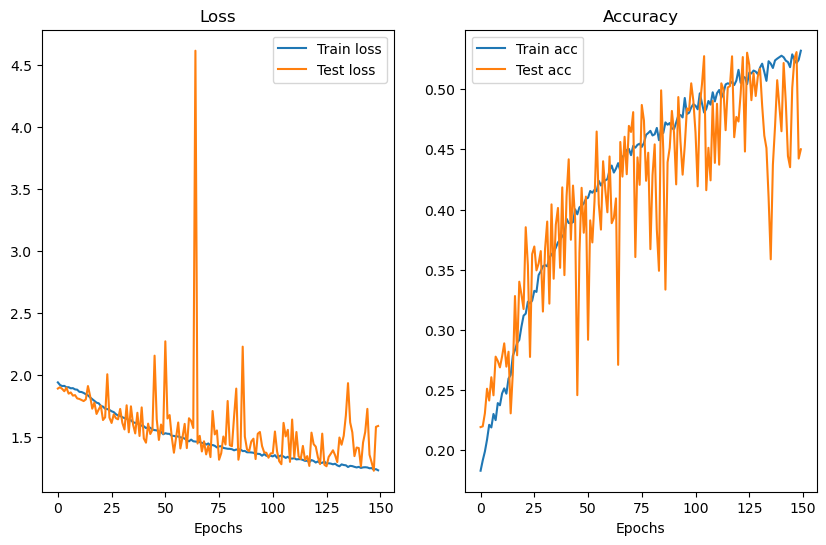

In [42]:
plot_loss_curve(model_0_result)

# 6. Make predictions using the trained model

## a) Functionalize making predictions

In [29]:
def make_preds(model: nn.Module, samples: list, device: torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for sample in samples:
            sample = torch.unsqueeze(sample, dim=0).to(device)

            logits = model(sample)
            pred_prob = torch.softmax(logits, dim=1)
            pred_probs.append(pred_prob)
    return torch.stack(pred_probs) # turn list of tensors to a tensor of tensors
        

## b) Get sample data from test dataset

In [30]:
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=20):
  test_samples.append(sample)
  test_labels.append(label)
test_labels[0]

1

## c) Making predictions and plot them

In [31]:
pred_probs = make_preds(model_0, test_samples)
pred_labels= torch.argmax(pred_probs, dim=2)
pred_labels.shape

W0303 15:36:14.140000 4458 site-packages/torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


torch.Size([20, 1])

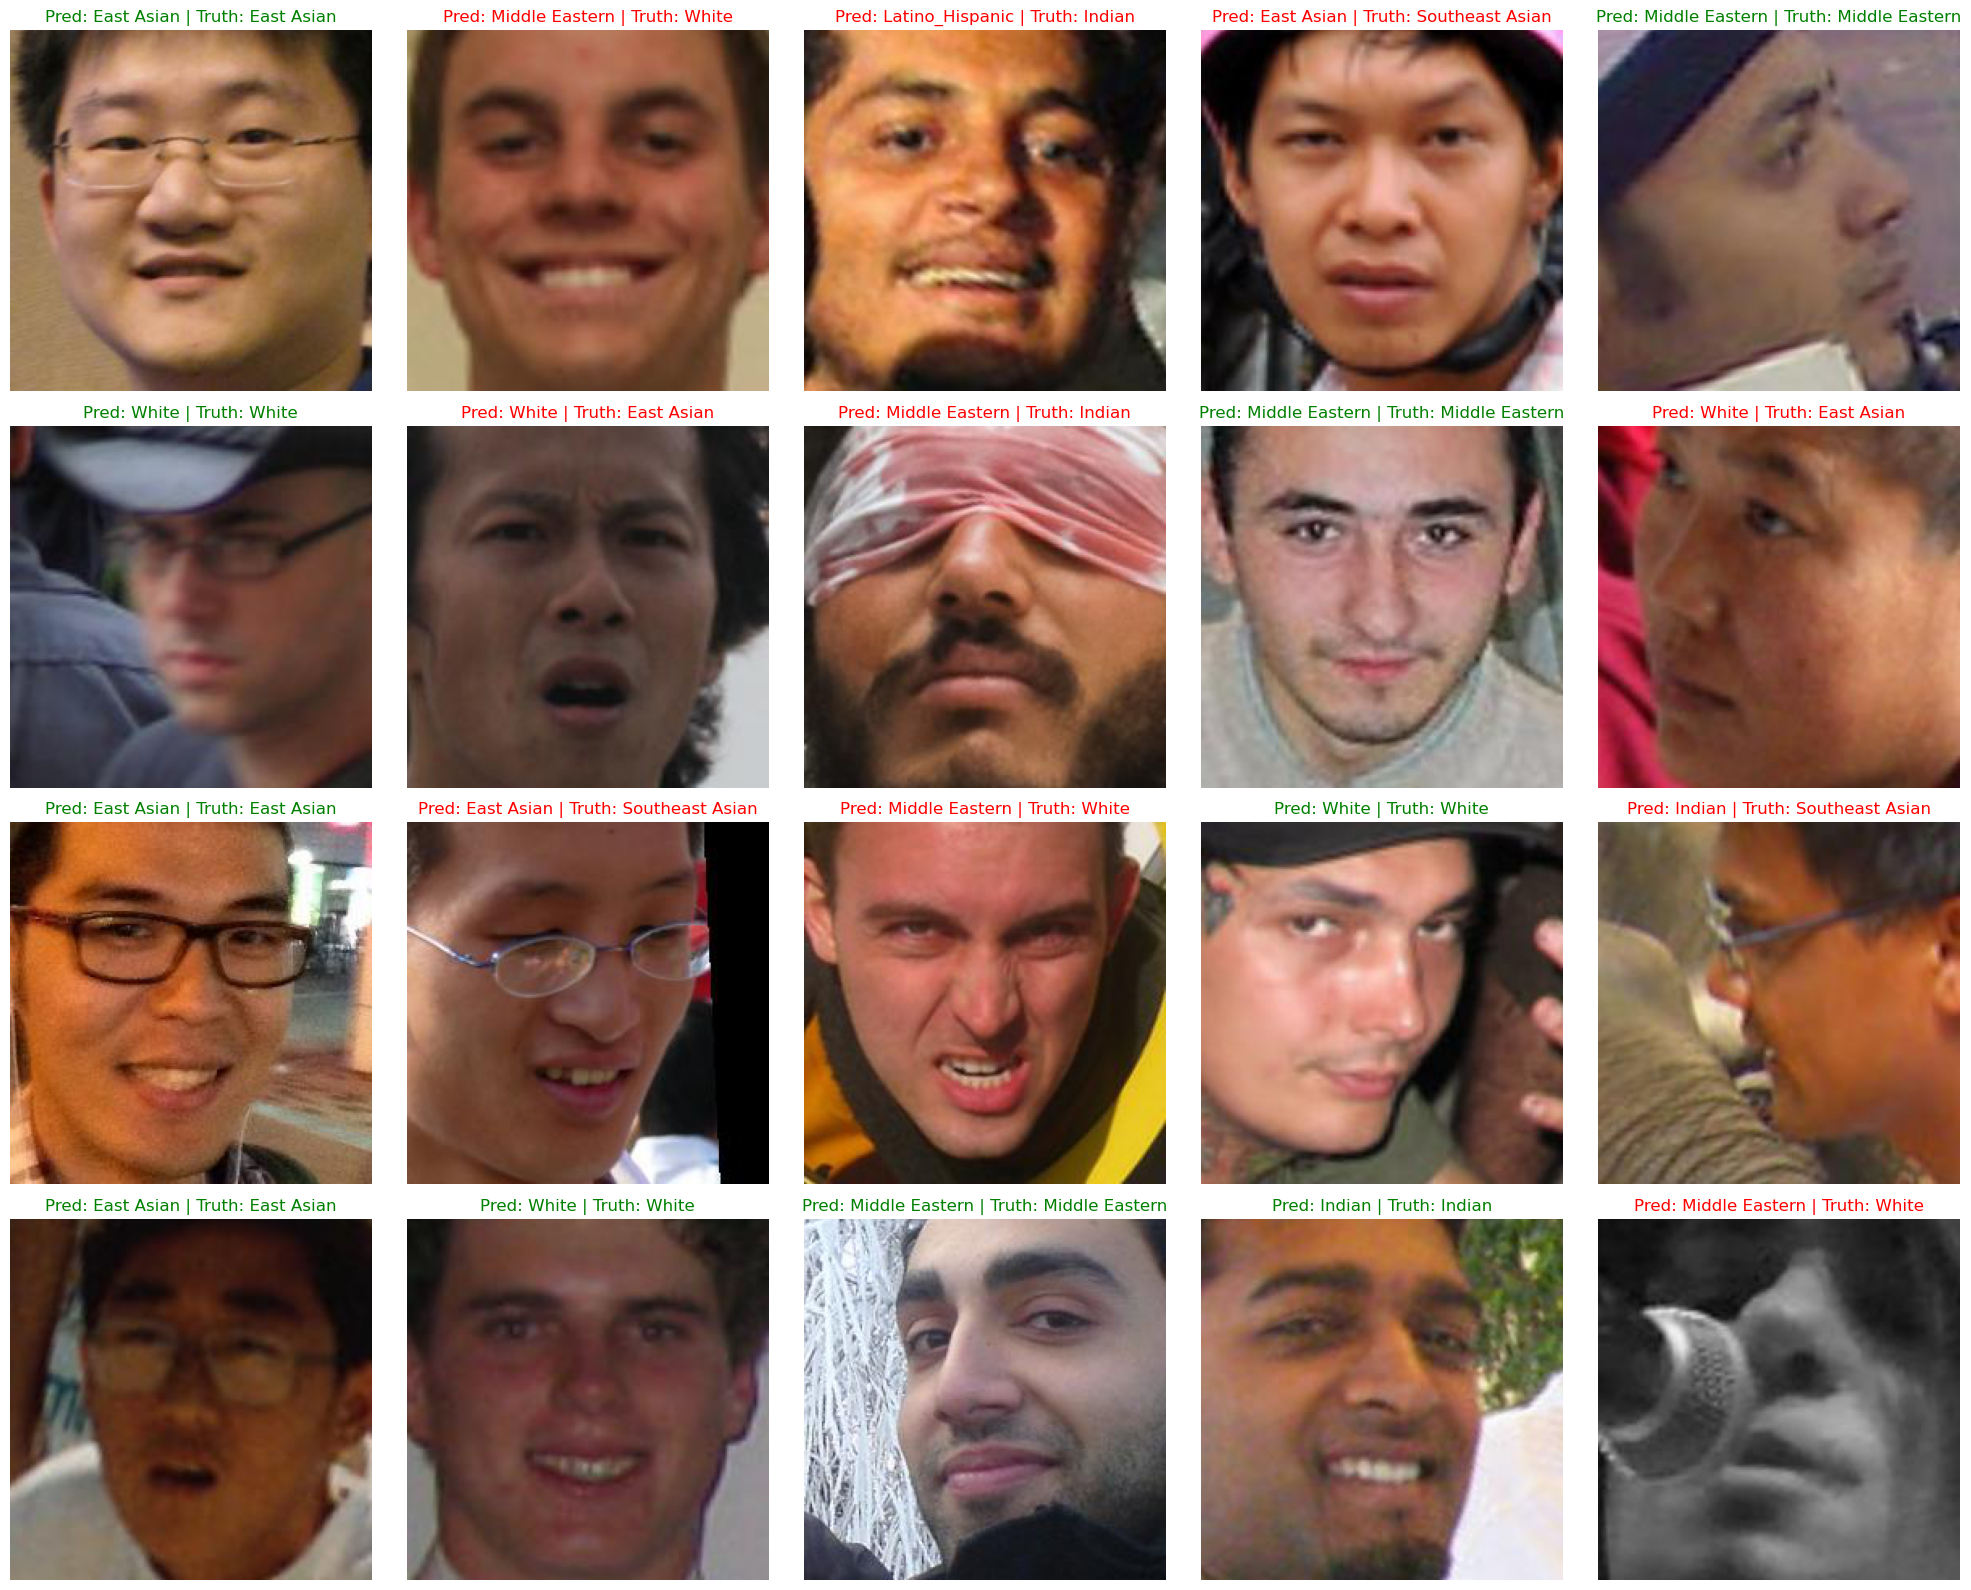

In [32]:
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(27)

plt.figure(figsize=(20, 16))
for i, sample in enumerate(test_samples):
    plt.subplot(4, 5, i+1)
    plt.imshow(sample.permute(1, 2, 0))
    title_text = f"Pred: {class_names[pred_labels[i]]} | Truth: {class_names[test_labels[i]]}"
    if pred_labels[i] == test_labels[i]:
        plt.title(title_text, c="g")
    else:
        plt.title(title_text, c="r")

    plt.axis('off')
plt.tight_layout()
plt.show()

## d) Making a confusion matrix

In [33]:
from tqdm.auto import tqdm
torch.manual_seed(27)
all_pred_labels = []
model_0.to(device)
model_0.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader):
        X, y = X.to(device), y.to(device)

        logits = model_0(X)
        label = torch.softmax(logits.squeeze(), dim=1).argmax(dim=1)
        all_pred_labels.append(label.cpu())
all_pred_labels_tensor = torch.cat(all_pred_labels) # list of single tensor -> tensor of elements

  0%|          | 0/36 [00:00<?, ?it/s]

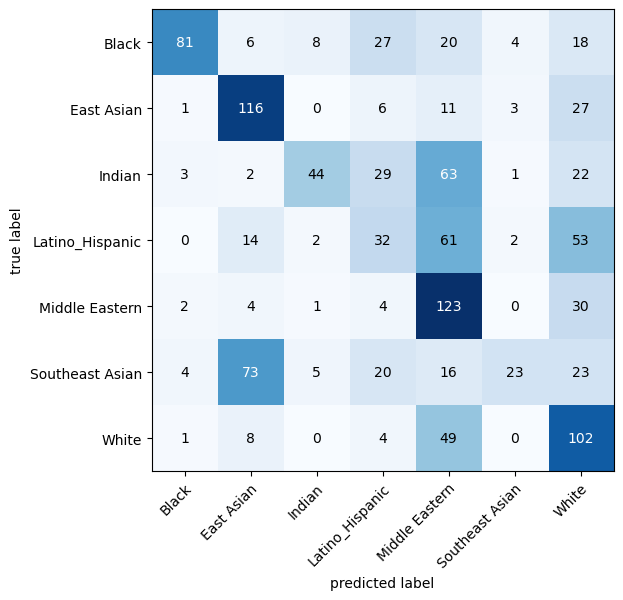

In [34]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

conf_mat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
conf_mat_tensor = conf_mat(preds=all_pred_labels_tensor, target=torch.tensor(test_data.targets))

fig, ax = plot_confusion_matrix(
    conf_mat=conf_mat_tensor.numpy(),
    class_names=class_names,
    figsize=(8,6)
)

In [136]:
class_train_imgs

{'Black': 1282,
 'East Asian': 1282,
 'Indian': 1282,
 'Latino_Hispanic': 1282,
 'Middle Eastern': 1282,
 'Southeast Asian': 1282,
 'White': 1282}

## e) Making prediction on a custom image

In [72]:
import torchvision
from torchvision import transforms
custom_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
])
def predict(img_path, model, classnames):
    img_uint8 = custom_transform(torchvision.io.read_image(img_path))
    img_f32 = img_uint8.type(torch.float32).unsqueeze(dim=0) / 255

    model.eval()
    with torch.inference_mode():
        logits = model(img_f32.to(device))
        pred_prob = torch.softmax(logits, dim=1)
        label = pred_prob.argmax(dim=1)
    
    plt.imshow(img_f32.squeeze().permute(1, 2, 0))
    plt.title(f"Pred label : {class_names[label]} | Pred prob : {pred_prob.cpu().numpy()}")
    plt.axis(False)

In [80]:
# CUSTOM_IMG_PATH = "custom imgs/4.jpg"
# predict(img_path=CUSTOM_IMG_PATH, model=model_0, classnames=class_names)

# 7. Saving the best model yet

In [24]:
import torch
MODEL_SAVE_PATH = "attempts/Custom Resnet/best(150_epochs+scheduler+dropout).pth"

In [25]:
torch.save(model_0, f=MODEL_SAVE_PATH)
print(f"Saved model to {MODEL_SAVE_PATH}")

Saved model to attempts/Custom Resnet/best(150_epochs+scheduler+dropout).pth


In [37]:
# Load in the best model
model_0 = torch.load(f=MODEL_SAVE_PATH,weights_only=False)
model_0

OptimizedModule(
  (_orig_mod): CustomResnet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): ResidualBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (skip): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (layer2): ResidualBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1,